# Reinforcement learning with spiking neural networks

In [1]:
# @title Install prerequisites
#!pip3 install norse matplotlib gym

%matplotlib inline

In [12]:
# @title Simulation setup
import gym
import matplotlib.pyplot as plt
import torch
import norse.torch as norse
import IPython.display as display
import rl # Init environment

def draw_network(ax, spikes):
    # Thanks to https://stackoverflow.com/a/67289898/999865
    top = .9
    bottom = .1
    left = .1
    right = .9
    layer_sizes = [len(x) for x in spikes]
    v_spacing = 1 / max(layer_sizes)
    h_spacing = 1 / len(spikes)
    # Nodes
    for n, layer_z in enumerate(spikes):
        layer_size = len(layer_z)
        layer_top = v_spacing * (layer_size - 1) / 2. + (top + bottom) / 2.

        for m in range(layer_size):
            center = (n * h_spacing + left, layer_top - m * v_spacing)
            radius = v_spacing / 4.

            circle = plt.Circle(center, radius, color='w', ec='k', zorder=4)
            ax.add_artist(circle)

        # Edges
        for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
            layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
            layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
            for m in range(layer_size_a):
                for o in range(layer_size_b):
                    line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                      [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                    ax.add_artist(line)
                    
def ask_network(model, observation, state=None):
    observation = torch.tensor(observation, dtype=torch.float32)
    action, state = model(observation, state)
    return action.detach().numpy(), state


def simulate(model):
    activities = []
    h = id(activities)
    def forward_state_hook(mod, inp, out):
        activities.append(out[0].detach())
    
    try:
        model.remove_forward_state_hooks()
        model.forward_state_hooks.clear()
        model.register_forward_state_hooks(forward_state_hook)
    except Exception as e:
        print(e)
        pass # Ignore if model already has registered hooks
    
    observation = env.reset()
    state = None
    is_done = False
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
    dis = display.display(f, display_id=True)
    ax1.axis('off')
    ax2.axis('off')
    img = ax1.imshow(env.render(mode='rgb_array')) # only call this once
    vs = [[0, 0]] * 50
    try:
        while not is_done:
            activities.clear()
            action, state = ask_network(model, observation, state)
            if len(vs) > 49:
                vs = vs[1:]
            observation, _, is_done, _ = env.step([1, 1])
            img.set_data(env.render(mode='rgb_array')) # just update the data
            draw_network(ax2, activities)
            #f.canvas.draw()
            dis.update(f)
            #display.clear_output(wait=True)
    except KeyboardInterrupt:
        pass
    
    
## Setup environment
env = gym.make("Gridworld-v0")

In [3]:
linear = torch.nn.Linear(2, 2, bias=False)
model = norse.SequentialState(
    norse.LIFCell(),
    linear,
    norse.LICell()
)

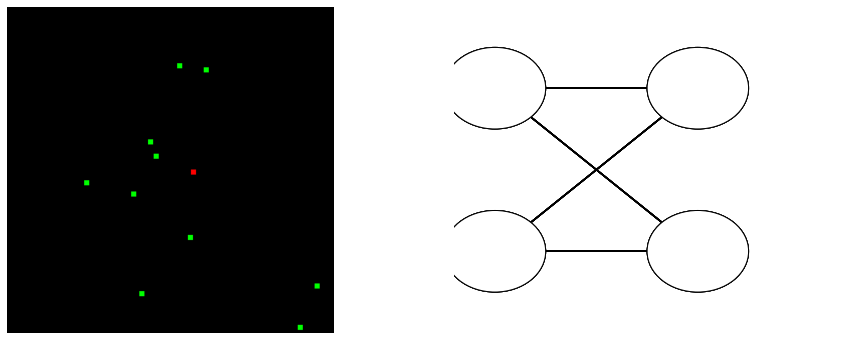

In [ ]:
simulate(model)